# Using MACD and RSI together

## MACD and RSI - Separate Strategies

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [25]:
data = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
data.head()

,BTC,ETH,LTC,DASH
Date,,,,
2016-01-01,434.334015,0.948024,3.50898,3.37702
2016-01-02,433.437988,0.937124,3.50216,3.28016
2016-01-03,430.010986,0.971905,3.48307,3.24014
2016-01-04,433.091003,0.954480,3.49539,3.31899
2016-01-05,431.959991,0.950176,3.46967,3.32576


In [26]:
symbol = "BTC"

__MACD__

In [27]:
class MACDBacktester(): 
    ''' Class for the vectorized backtesting of MACD-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    signal_mw: int
        time window is days for MACD Signal 
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets new MACD parameter(s)
        
    test_strategy:
        runs the backtest for the MACD-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates MACD parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the three MACD parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, signal_mw, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.signal_mw = signal_mw
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "MACDBacktester(symbol = {}, MACD({}, {}, {}), start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
        raw["MACD"] = raw.EMA_S - raw.EMA_L
        raw["MACD_Signal"] = raw.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean() 
        self.data = raw
      
        
    def set_parameters(self, EMA_S = None, EMA_L = None, signal_mw = None):
        ''' Updates MACD parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if signal_mw is not None:
            self.signal_mw = signal_mw
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["MACD"] > data["MACD_Signal"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | MACD ({}, {}, {}) | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, MACD):
        ''' Updates MACD parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        MACD: tuple
            MACD parameter tuple
        '''
        self.set_parameters(int(MACD[0]), int(MACD[1]), int(MACD[2]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA_S_range, EMA_L_range, signal_mw_range):
        ''' Finds global maximum given the MACD parameter ranges.

        Parameters
        ==========
        EMA_S_range, EMA_L_range, signal_mw_range : tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA_S_range, EMA_L_range, signal_mw_range), finish=None)
        return opt, -self.update_and_run(opt)

In [28]:
tester = MACDBacktester("BTC", EMA_S = 12, EMA_L = 26, signal_mw = 9,
              start = "2016-01-01", end = "2021-03-07", tc = 0)

In [29]:
tester.test_strategy()

(131.411443,
 0.639397,
 0.0    1735
 2.0     115
 Name: trades, dtype: int64)

In [30]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([10., 24., 16.]), 639.27081)

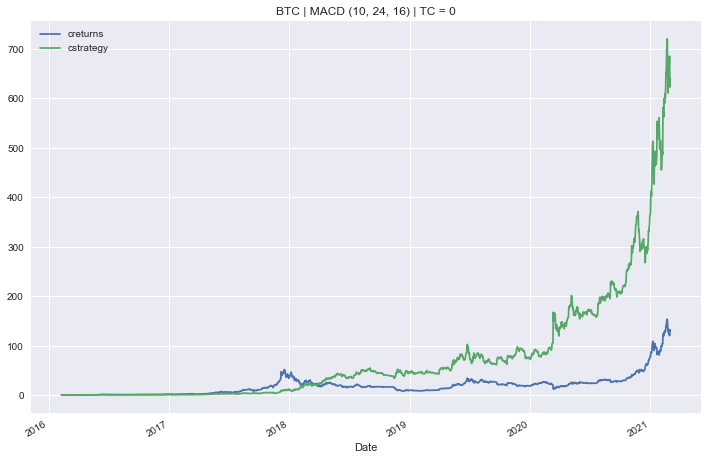

In [31]:
tester.plot_results()

In [32]:
macd = tester.results
macd.head()

,price,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2016-02-09,376.028992,0.006890,378.514835,385.805406,-7.290571,-8.678013,1,0.006890,0.0,1.006914,1.006914
2016-02-10,381.648987,0.014835,379.084833,385.461632,-6.376799,-8.375490,1,0.014835,0.0,1.021963,1.021963
2016-02-11,379.653992,-0.005241,379.188339,384.982584,-5.794245,-8.040777,1,-0.005241,0.0,1.016621,1.016621
2016-02-12,384.263000,0.012067,380.111170,384.923376,-4.812206,-7.627099,1,0.012067,0.0,1.028963,1.028963
2016-02-13,391.859985,0.019577,382.247631,385.492830,-3.245199,-7.071469,1,0.019577,0.0,1.049306,1.049306


__RSI__

In [33]:
class RSIBacktester(): 
    ''' Class for the vectorized backtesting of RSI-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    periods: int
        time window in days to calculate moving average UP & DOWN 
    rsi_upper: int
        upper rsi band indicating overbought instrument
    rsi_lower: int
        lower rsi band indicating oversold instrument
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets new RSI parameter(s)
        
    test_strategy:
        runs the backtest for the RSI-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates RSI parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the three RSI parameters
    '''
    
    def __init__(self, symbol, periods, rsi_upper, rsi_lower, start, end, tc):
        self.symbol = symbol
        self.periods = periods
        self.rsi_upper = rsi_upper
        self.rsi_lower = rsi_lower
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "RSIBacktester(symbol = {}, RSI({}, {}, {}), start = {}, end = {})".format(self.symbol, self.periods, self.rsi_upper, self.rsi_lower, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["U"] = np.where(raw.price.diff() > 0, raw.price.diff(), 0) 
        raw["D"] = np.where(raw.price.diff() < 0, -raw.price.diff(), 0)
        raw["MA_U"] = raw.U.rolling(self.periods).mean()
        raw["MA_D"] = raw.D.rolling(self.periods).mean()
        raw["RSI"] = raw.MA_U / (raw.MA_U + raw.MA_D) * 100
        self.data = raw 
        
    def set_parameters(self, periods = None, rsi_upper = None, rsi_lower = None):
        ''' Updates RSI parameters and resp. time series.
        '''
        if periods is not None:
            self.periods = periods     
            self.data["MA_U"] = self.data.U.rolling(self.periods).mean()
            self.data["MA_D"] = self.data.D.rolling(self.periods).mean()
            self.data["RSI"] = self.data.MA_U / (self.data.MA_U + self.data.MA_D) * 100
            
        if rsi_upper is not None:
            self.rsi_upper = rsi_upper
            
        if rsi_lower is not None:
            self.rsi_lower = rsi_lower
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data.RSI > self.rsi_upper, -1, np.nan)
        data["position"] = np.where(data.RSI < self.rsi_lower, 1, data.position)
        data.position = data.position.fillna(0)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | RSI ({}, {}, {}) | TC = {}".format(self.symbol, self.periods, self.rsi_upper, self.rsi_lower, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, RSI):
        ''' Updates RSI parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        RSI: tuple
            RSI parameter tuple
        '''
        self.set_parameters(int(RSI[0]), int(RSI[1]), int(RSI[2]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, periods_range, rsi_upper_range, rsi_lower_range):
        ''' Finds global maximum given the RSI parameter ranges.

        Parameters
        ==========
        periods_range, rsi_upper_range, rsi_lower_range : tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (periods_range, rsi_upper_range, rsi_lower_range), finish=None)
        return opt, -self.update_and_run(opt)

In [34]:
tester = RSIBacktester("BTC", periods = 20, rsi_upper = 70, rsi_lower = 30,
              start = "2016-01-01", end = "2021-03-07", tc = 0)

In [35]:
tester.test_strategy()

(0.021861,
 -115.103159,
 0.0    1698
 1.0     166
 Name: trades, dtype: int64)

In [36]:
tester.optimize_parameters((5, 20, 1), (65, 80, 1), (20, 35, 1)) # higher volatility

(array([18., 79., 24.]), 0.378729)

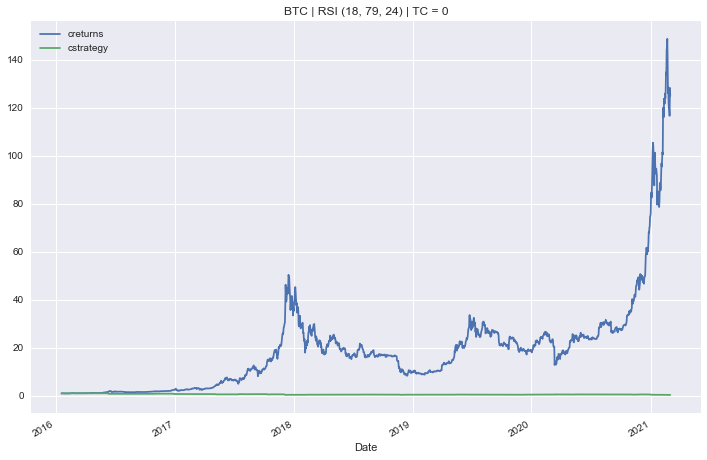

In [37]:
tester.plot_results()

In [38]:
rsi = tester.results
rsi.head()

,price,returns,U,D,MA_U,MA_D,RSI,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,,
2016-01-19,380.148987,-0.018295,0.000000,7.019012,3.384113,6.394392,34.607671,0.0,-0.0,0.0,0.981871,1.0
2016-01-20,420.230011,0.100239,40.081024,0.000000,5.610836,6.344613,46.931205,0.0,0.0,0.0,1.085394,1.0
2016-01-21,410.261993,-0.024006,0.000000,9.968018,5.610836,6.708003,45.546795,0.0,-0.0,0.0,1.059649,1.0
2016-01-22,382.492004,-0.070088,0.000000,27.769989,5.439724,8.250780,39.733557,0.0,-0.0,0.0,0.987923,1.0
2016-01-23,387.490997,0.012985,4.998993,0.000000,5.717446,8.187946,41.116757,0.0,0.0,0.0,1.000834,1.0


## Combination

In [ ]:
#o certo https://python.plainenglish.io/the-rsi-macd-technical-indicator-a-python-study-71cf949707eb

In [16]:
#NÃO FUNCIONA

#MACD E RSI possuem datas diferentes, quando realiza o que o autor propos todas as datas ficam parelhas no MACD, o qeu não reflete o estado do RSI naquele momento

comb = macd.loc[:, ["returns", "position"]].copy()

In [17]:
comb

,returns,position
Date,,
2016-02-09,0.006890,1
2016-02-10,0.014835,1
2016-02-11,-0.005241,1
2016-02-12,0.012067,1
2016-02-13,0.019577,1
...,...,...
2021-02-26,-0.016142,-1
2021-02-27,-0.003271,-1
2021-02-28,-0.023010,-1


In [18]:
comb.rename(columns = {"position":"position_MACD"}, inplace = True)

In [21]:
comb

,returns,position_MACD
Date,,
2016-02-09,0.006890,1
2016-02-10,0.014835,1
2016-02-11,-0.005241,1
2016-02-12,0.012067,1
2016-02-13,0.019577,1
...,...,...
2021-02-26,-0.016142,-1
2021-02-27,-0.003271,-1
2021-02-28,-0.023010,-1


In [20]:
comb["position_RSI"] = rsi.position.astype("int")

NameError: name 'comb1' is not defined

In [ ]:
comb

In [ ]:
comb["position_comb"] = np.where(comb.position_MACD == comb.position_RSI, comb.position_MACD, 0)

In [ ]:
comb.position_comb.value_counts()

In [ ]:
comb.position_comb.plot(figsize = (12, 8))
plt.show()

In [ ]:
comb["strategy"] = comb["position_comb"].shift(1) * comb["returns"]

In [ ]:
comb

In [ ]:
comb.dropna(inplace=True)

In [ ]:
comb["trades"] = comb.position_comb.diff().fillna(0).abs()

In [ ]:
comb.strategy = comb.strategy - comb.trades * ptc

In [ ]:
comb["creturns"] = comb["returns"].cumsum().apply(np.exp)
comb["cstrategy"] = comb["strategy"].cumsum().apply(np.exp)

In [ ]:
comb[["creturns", "cstrategy"]].plot(figsize = (12, 8), fontsize = 12)
plt.legend(fontsize = 12)
plt.show()